## Visualize correlation heatmaps across profiles with metadata

Gregory Way, 2021

Yu Han, Nov. 2021

Modified Greg's original script of 7.profile-heatmaps.ipynb for tasks described in https://github.com/broadinstitute/profiling-resistance-mechanisms/issues/119, and included the new batch dataset.  

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(devtools))
source(file.path("utils/viz.R"))

In [2]:
# The correct version of ComplexHeatmap was not available on anaconda
# https://anaconda.org/bioconda/bioconductor-complexheatmap
# Install it here
if (!("ComplexHeatmap" %in% rownames(installed.packages()))) {
    install_github("jokergoo/ComplexHeatmap")
}

suppressPackageStartupMessages(library(ComplexHeatmap))

In [3]:
# Set constants
dataset <- "bortezomib"
data_dir <- "data"

output_dir <- file.path("figures", "heatmaps")

lgd_title_fontsize = 9
lgd_label_fontsize = 6.5
anno_name_height = 0.45

In [4]:
# Load profiles
dataset_file <- file.path(data_dir, paste0(dataset, "_signature_analytical_full_set.csv"))

data_cols <- readr::cols(
    .default = readr::col_double(),
    Metadata_Plate = readr::col_character(),
    Metadata_Well = readr::col_character(),
    Metadata_cell_count = readr::col_integer(),
    Metadata_batch = readr::col_character(),
    Metadata_clone_number = readr::col_character(),
    Metadata_plate_map_name = readr::col_character(),
    Metadata_treatment = readr::col_character(),
    Metadata_dataset = readr::col_character(),
    Metadata_clone_type = readr::col_character(),
    Metadata_clone_type_indicator = readr::col_character(),
    Metadata_model_split = readr::col_character(),
    Metadata_cell_density = readr::col_character(),
    Metadata_treatment_time = readr::col_character(),
    Metadata_unique_sample_name = readr::col_character(),
    Metadata_time_to_adhere = readr::col_character()
)

dataset_df <- readr::read_csv(dataset_file, col_types=data_cols)

print(dim(dataset_df))
head(dataset_df, 3)

[1] 1220 3546


Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Center_Z,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MajorAxisLength,⋯,Nuclei_Texture_Variance_RNA_10_02,Nuclei_Texture_Variance_RNA_10_03,Nuclei_Texture_Variance_RNA_20_00,Nuclei_Texture_Variance_RNA_20_01,Nuclei_Texture_Variance_RNA_20_02,Nuclei_Texture_Variance_RNA_20_03,Nuclei_Texture_Variance_RNA_5_00,Nuclei_Texture_Variance_RNA_5_01,Nuclei_Texture_Variance_RNA_5_02,Nuclei_Texture_Variance_RNA_5_03
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.7884911,0.1895906,0.004760102,0,-0.81105470,-0.7400503,0,-0.08129640,-0.1697668,-0.745275759,⋯,-0.6430638,-0.6342366,-0.6554599,-0.6673215,-0.6546287,-0.6977682,-0.6320059,-0.6297243,-0.6345844,-0.6329460
-0.1694929,-0.6835772,0.450584298,0,0.07329018,-0.6693416,0,-0.07857756,-0.8527054,0.026146569,⋯,-0.8308873,-0.8344854,-0.8304672,-0.8178338,-0.8309076,-0.8234369,-0.8347194,-0.8332018,-0.8327623,-0.8296075
-0.2024183,-0.1418898,0.241604206,0,0.55343997,-0.8487885,0,-0.46787336,-1.2607533,-0.002624584,⋯,-0.9813265,-0.9759700,-0.9728225,-0.9617426,-0.9721434,-0.9618017,-0.9802334,-0.9790954,-0.9839611,-0.9793490


In [5]:
# Load signatures
sig_dir <- file.path("results", "signatures")
signature_file <- file.path(sig_dir, paste0("signature_summary_", dataset, "_signature.tsv.gz"))

sig_col_types <- readr::cols(
    features = readr::col_character(),
    non_specific_exclude = readr::col_logical(),
    final_signature = readr::col_logical(),
    dataset = readr::col_character()
)

signature_df <- readr::read_tsv(signature_file, col_types = sig_col_types)

print(dim(signature_df))
head(signature_df, 4)

[1] 782   8


features,non_status_significant_exclude,batch_exclude,cell_count_exclude,non_specific_exclude,treatment_time_exclude,final_signature,dataset
<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>
Cells_AreaShape_Compactness,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,bortezomib
Cells_AreaShape_Eccentricity,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,bortezomib
Cells_AreaShape_Extent,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,bortezomib
Cells_AreaShape_FormFactor,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,bortezomib


In [6]:
# Load feature selection results
feat_file <- file.path(data_dir, "dataset_features_selected.tsv")

feat_cols <- readr::cols(
  features = readr::col_character(),
  dataset = readr::col_character()
)

features_df <- readr::read_tsv(feat_file, col_types = feat_cols)

print(dim(features_df))
head(features_df, 3)

[1] 782   2


features,dataset
<chr>,<chr>
Cells_AreaShape_Compactness,bortezomib
Cells_AreaShape_Eccentricity,bortezomib
Cells_AreaShape_Extent,bortezomib


In [7]:
# Load signature scores
score_dir <- file.path("results", "singscore")
score_file <- file.path(score_dir, paste0("singscore_results_", dataset, "_full_set.csv"))

score_cols <- readr::cols(
    .default = readr::col_character(),
    Metadata_clone_type_indicator = readr::col_integer(),
    Metadata_celltype_shorthand_from_plate_graph = readr::col_integer(),
    Metadata_date = readr::col_integer(),
    Metadata_treatment_shorthand_from_plate_graph = readr::col_integer(),
    TotalScore = readr::col_double(),
    TotalDispersion = readr::col_double(),
    UpScore = readr::col_double(),
    UpDispersion = readr::col_double(),
    DownScore = readr::col_double(),
    DownDispersion = readr::col_double(),
    Metadata_permuted_p_value = readr::col_double(),
    min_permuted_value = readr::col_double(),
    max_permuted_value = readr::col_double()
)

score_df <- readr::read_csv(score_file, col_types = score_cols)
print(dim(score_df))
head(score_df, 3)

Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“3660 parsing failures.
row # A tibble: 5 x 5 col     row col                    expected       actual file                        expected   <int> <chr>                  <chr>          <chr>  <chr>                       actual 1     1 Metadata_celltype_sho… no trailing c… .0     'results/singscore/singsco… file 2     1 Metadata_date          no trailing c… .0     'results/singscore/singsco… row 3     1 Metadata_treatment_sh… no trailing c… .0     'results/singscore/singsco… col 4     2 Metadata_celltype_sho… no trailing c… .0     'results/singscore/singsco… expected 5     2 Metadata_date          no trailing c… .0     'results/singscore/singsco…
... ........................... ... ................................................................................ ........ .................................................................................

[1] 1325   28


DownDispersion,DownScore,Metadata_Plate,Metadata_Well,Metadata_batch,Metadata_cell_count,Metadata_cell_density,Metadata_celltype_shorthand_from_plate_graph,Metadata_clone_number,Metadata_clone_type,⋯,Metadata_treatment_shorthand_from_plate_graph,Metadata_treatment_time,Metadata_unique_sample_name,TotalDispersion,TotalScore,UpDispersion,UpScore,dataset,max_permuted_value,min_permuted_value
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,⋯,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
200.1510,0.003371848,219907,B02,2021_03_03_Batch12,6139,2.5x10^3 cells/well,NA,WT_parental,sensitive,⋯,NA,13 hr,profile_0_bortezomib,385.4760,-0.15194809,185.3250,-0.1553199,bortezomib,0.1589312,-0.1548019
169.0164,0.057750956,219907,B03,2021_03_03_Batch12,4567,2.5x10^3 cells/well,NA,CloneA,resistant,⋯,NA,13 hr,profile_1_bortezomib,519.6513,-0.03125574,350.6349,-0.0890067,bortezomib,0.1589312,-0.1548019
186.8076,0.111743482,219907,B04,2021_03_03_Batch12,5624,2.5x10^3 cells/well,NA,CloneE,resistant,⋯,NA,13 hr,profile_2_bortezomib,471.4668,0.00999497,284.6592,-0.1017485,bortezomib,0.1589312,-0.1548019


In [8]:
# Set colors
legend_scale_cols = circlize::colorRamp2(c(-1, 0, 1), c("blue", "white", "red"))

legend_colors = c(
        "otherclone"="#66C2A5",
        "test"="#FC8D62",
        "training"="#8DA0CB",
        "validation"="#E78AC3",
        "holdout"="#A6D854"
        )


plate_col = c(
    "219901" = "#E1DAAE",
    "219907" = "#FF934F",
    "219956" = "#CC2D35",
    "219973" = "#058ED9",
    "220039" = "#848FA2",
    "220040" = "#2D3142",
    "220055" = "#FFC857",
    "221093" = "#E495A5",
    "221094" = "#ABB065",
    "221058" = "#39BEB1",
    "221057" = "#ACA4E2"
    
)

clonetype_col = c("Clone" = "#785EF0", "Parental" = "#DC267F")

# From colorbrewer2.org
spectral_palette <- c(
    '#9e0142',
    '#d53e4f',
    '#f46d43',
    '#fdae61',
    '#fee08b',
    '#ffffbf',
    '#e6f598',
    '#abdda4',
    '#66c2a5',
    '#3288bd',
    '#5e4fa2'
)

spectral_limits <- c(-1, 1) * max(abs(score_df$TotalScore))
spectral_breaks <- seq(spectral_limits[1] * 100, spectral_limits[2] * 100, length(spectral_palette) + 1) / 100

signature_col = circlize::colorRamp2(rev(spectral_breaks), spectral_palette)
sensitivity_col = c("resistant" = "#332a2a", "sensitive" = "#c3c7c9")

In [9]:
#for (feature_select_type in c("selected", "signature")) {
    
    feature_select_type <- "signature"
    # Determine features that were selected for the dataset
    if (feature_select_type == "signature") {
        # Signature only features
        selected_features <- signature_df %>%
            dplyr::filter(final_signature) %>%
            dplyr::pull(features)
    } else {
        # Features that survived the standard feature selection steps
        selected_features <- features_df %>%
            dplyr::filter(dataset == !!dataset) %>%
            dplyr::pull(features)
    }

    # Subset the signature results for later merge
    subset_score_df <- score_df %>%
        dplyr::filter(dataset == !!dataset) %>%
        dplyr::select(Metadata_unique_sample_name, TotalScore)

    # Subset the data to only these features
    subset_data_df <- dataset_df %>%
        dplyr::filter(Metadata_dataset == !!dataset) %>%
        dplyr::select(starts_with("Metadata_"), !!!selected_features) %>%
        dplyr::filter(Metadata_treatment == "0.1% DMSO")  %>%
        dplyr::left_join(subset_score_df, by = "Metadata_unique_sample_name") %>%
        dplyr::mutate(Metadata_parental = "Clone")


In [10]:
total_score<-subset_data_df$TotalScore
subset_data_df = subset(subset_data_df, select = -c(TotalScore) )
subset_data_df[order(as.character(subset_data_df$Metadata_clone_type)),]

Metadata_Plate,Metadata_Well,Metadata_batch,Metadata_cell_count,Metadata_cell_density,Metadata_celltype_shorthand_from_plate_graph,Metadata_clone_number,Metadata_clone_type,Metadata_clone_type_indicator,Metadata_dataset,⋯,Nuclei_Texture_Correlation_DNA_10_02,Nuclei_Texture_Correlation_DNA_5_00,Nuclei_Texture_Correlation_Mito_10_00,Nuclei_Texture_Correlation_Mito_10_01,Nuclei_Texture_Correlation_Mito_10_02,Nuclei_Texture_Correlation_Mito_10_03,Nuclei_Texture_Correlation_RNA_10_01,Nuclei_Texture_Correlation_RNA_10_03,Nuclei_Texture_InfoMeas1_RNA_5_00,Metadata_parental
<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
219907,B03,2021_03_03_Batch12,4567,2.5x10^3 cells/well,2,CloneA,resistant,1,bortezomib,⋯,-0.01984253,0.02543908,-0.53542635,-0.14849690,-0.35174491,-0.1942648,-0.082559313,-0.00257280,0.5185727,Clone
219907,B04,2021_03_03_Batch12,5624,2.5x10^3 cells/well,3,CloneE,resistant,1,bortezomib,⋯,-0.95916042,-0.97166091,-0.59091652,-0.47579586,-0.31363599,-0.7274795,-0.659456756,-0.86421542,0.9943957,Clone
219907,B08,2021_03_03_Batch12,3252,2.5x10^3 cells/well,2,CloneA,resistant,1,bortezomib,⋯,0.60330436,0.58125129,0.41705242,0.54821163,0.07160338,0.4012167,0.660001514,0.70076816,-0.1486757,Clone
219907,B09,2021_03_03_Batch12,5113,2.5x10^3 cells/well,3,CloneE,resistant,1,bortezomib,⋯,-1.12371100,-0.95740022,-0.85988366,-1.12573958,-0.78142442,-1.2303703,-1.072815058,-1.29102367,1.1790351,Clone
219907,C02,2021_03_03_Batch12,3223,2.5x10^3 cells/well,10,BZ002,resistant,1,bortezomib,⋯,0.78341987,0.68059202,-0.77454940,-0.09490671,-0.98319529,-0.3535757,0.783446695,0.78447021,-0.2795598,Clone
219907,C03,2021_03_03_Batch12,2347,2.5x10^3 cells/well,9,BZ001,resistant,1,bortezomib,⋯,0.57791551,0.74686591,-1.93745231,-1.22196629,-1.92843008,-1.2238115,0.577807186,0.69443331,-1.0566628,Clone
219907,C07,2021_03_03_Batch12,3382,2.5x10^3 cells/well,10,BZ002,resistant,1,bortezomib,⋯,0.12145740,0.22701997,-0.93195407,-0.28784755,-0.82332621,-0.6651307,0.340822554,0.05674189,-0.1781666,Clone
219907,C08,2021_03_03_Batch12,1794,2.5x10^3 cells/well,9,BZ001,resistant,1,bortezomib,⋯,0.40836906,0.82228501,-2.29476757,-1.64435565,-2.33411459,-1.2045947,0.415358778,0.99081095,-1.3426047,Clone
219907,D02,2021_03_03_Batch12,2765,2.5x10^3 cells/well,11,BZ003,resistant,1,bortezomib,⋯,0.28668545,0.38287931,-0.60565570,-0.41150071,-0.56348813,-0.5133010,0.144508704,0.24699511,-0.7253173,Clone


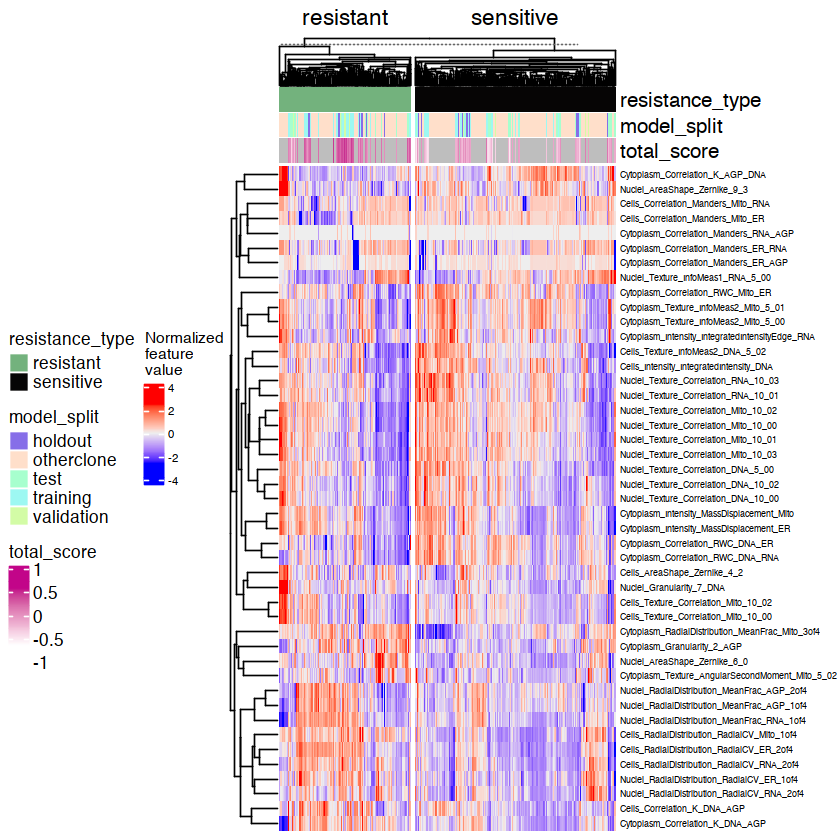

In [11]:
ht=
Heatmap(
   subset_data_df%>% select(-matches("Metadata")) %>% select(1:45) %>% as.matrix() %>% t(),
       top_annotation = HeatmapAnnotation(
       resistance_type = subset_data_df %>% pull(Metadata_clone_type),
       model_split= subset_data_df %>% pull(Metadata_model_split),
       total_score=total_score
      ),
      
       heatmap_legend_param = list(
            title = "Normalized\nfeature\nvalue",
            color_bar = "continuous",
            title_gp = gpar(fontsize = lgd_title_fontsize),
            title_position = "topleft",
            col_fun = legend_scale_cols,
            labels_gp = gpar(fontsize = lgd_label_fontsize)
            
      ),
    row_names_gp = gpar(fontsize = 5),
    clustering_method_columns = "average",
    clustering_method_rows = "average",
    column_split = subset_data_df %>% pull(Metadata_clone_type)
    )
    

draw(ht,annotation_legend_side = "left", heatmap_legend_side = "left")